# **Import thư viện**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tempfile import TemporaryDirectory

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
import torchvision
from torchvision import datasets, models, transforms

!pip install wandb
!wandb login d77624ba279c6354e2d27130c47fa3faf424ea9d
import wandb


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# **Location of data**

In [2]:
train_dir = '/kaggle/input/wb-recognition-dataset/wb_recognition_dataset/train'
val_dir = '/kaggle/input/wb-recognition-dataset/wb_recognition_dataset/val'

# **Phân tích số lượng ảnh trong các class của train**

Tập train:
Class có nhiều ảnh nhất: 1677, số lượng ảnh: 285
Class có ít ảnh nhất: 954, số lượng ảnh: 1
Giá trị trung bình: 26.672769953051642
Độ lệch chuẩn: 17.114539856127728
Data tập trung chủ yếu trong khoảng từ 9 đến 43 ảnh.


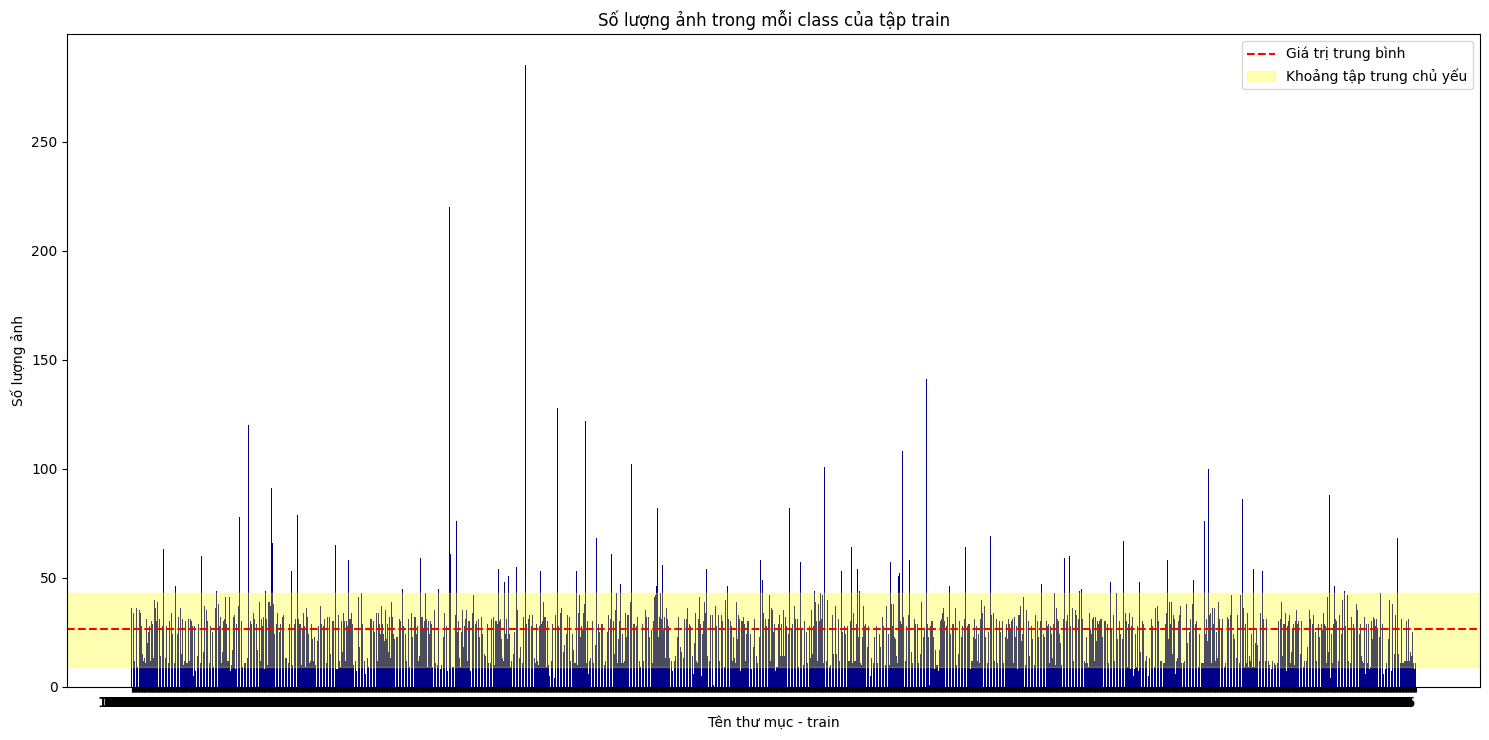

In [9]:
# Hàm tính toán số lượng hình ảnh trong mỗi thư mục con của một thư mục chứa dữ liệu hình ảnh
def calculate_image_counts(folder_path):
    image_counts = {}

    for folder_name in os.listdir(folder_path):
        folder_dir = os.path.join(folder_path, folder_name)
        if os.path.isdir(folder_dir):
            num_images = len(os.listdir(folder_dir))
            image_counts[folder_name] = num_images
    return image_counts

# Tính toán số lượng hình ảnh trong train
train_image_counts = calculate_image_counts(train_dir)

# Tìm class có nhiều hình ảnh nhất, ít hình ảnh nhất, giá trị trung bình, độ lệch chuẩn và khoảng tập trung chủ yếu
train_most_images_folder = max(train_image_counts, key=train_image_counts.get)
train_least_images_folder = min(train_image_counts, key=train_image_counts.get)
train_mean_count = np.mean(list(train_image_counts.values()))
train_std_dev = np.std(list(train_image_counts.values()))
train_lower_bound = int(train_mean_count - train_std_dev)
train_upper_bound = int(train_mean_count + train_std_dev)

# In ra các thông tin về số lượng hình ảnh trong train
print("Tập train:")
print(f"Class có nhiều ảnh nhất: {train_most_images_folder}, số lượng ảnh: {train_image_counts[train_most_images_folder]}")
print(f"Class có ít ảnh nhất: {train_least_images_folder}, số lượng ảnh: {train_image_counts[train_least_images_folder]}")
print(f"Giá trị trung bình: {train_mean_count}")
print(f"Độ lệch chuẩn: {train_std_dev}")
print(f"Data tập trung chủ yếu trong khoảng từ {train_lower_bound} đến {train_upper_bound} ảnh.")

folders_train = list(train_image_counts.keys())
counts_train = list(train_image_counts.values())

plt.figure(figsize=(15, 7.5))
plt.bar(folders_train, counts_train, color='darkblue')
plt.xlabel('Tên thư mục - train')
plt.ylabel('Số lượng ảnh')
plt.title('Số lượng ảnh trong mỗi class của tập train')
plt.xticks(rotation=0, ha='right')
plt.axhline(train_mean_count, color='red', linestyle='--', label='Giá trị trung bình')
plt.axhspan(train_lower_bound, train_upper_bound, color='yellow', alpha=0.3, label='Khoảng tập trung chủ yếu')
plt.legend()
plt.tight_layout()
plt.show()

# **Tìm tần suất xuất hiện của số lượng ảnh trong từng class**

Số lượng ảnh xuất hiện nhiều nhất trong mỗi class - train: 29
Tần suất xuất hiện của số lượng ảnh này trong tập train: 168


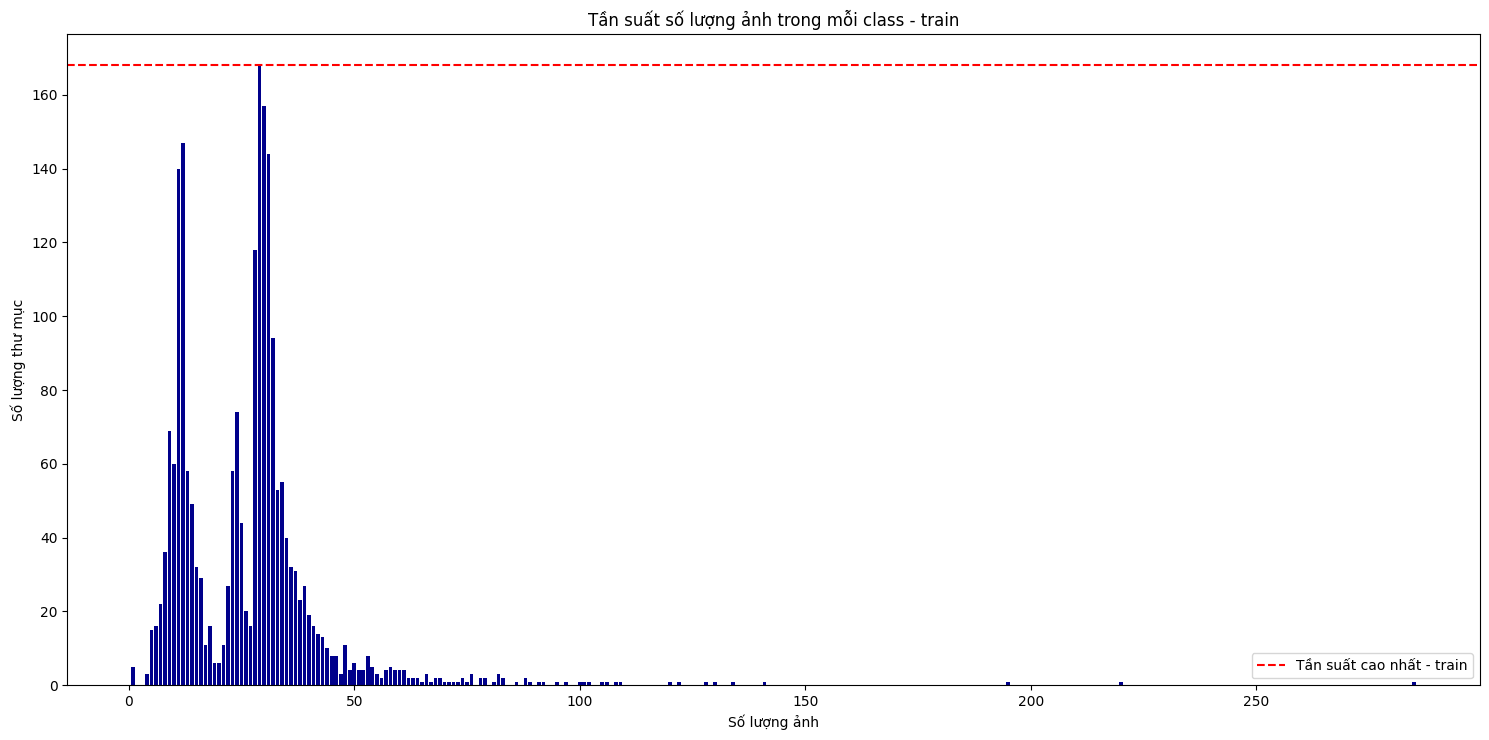

In [12]:
# Hàm đếm số lượng hình ảnh trong từng thư mục con của một thư mục chứa dữ liệu hình ảnh
def count_images_in_subfolders(folder_path):
    image_counts = [] 
 
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):  
            num_images = len(os.listdir(subfolder_path)) 
            image_counts.append(num_images)  

    return image_counts  

# Đếm số lượng hình ảnh trong train
train_image_counts = count_images_in_subfolders(train_dir)

# Đếm tần suất của số lượng hình ảnh và hiển thị biểu đồ tần suất
train_count_of_counts = Counter(train_image_counts)

# Lấy số lượng hình ảnh xuất hiện nhiều nhất và tần suất của nó
train_most_common_count, train_frequency = train_count_of_counts.most_common(1)[0]

# In thông tin về số lượng hình ảnh xuất hiện nhiều nhất trong train
print(f"Số lượng ảnh xuất hiện nhiều nhất trong mỗi class - train: {train_most_common_count}")
print(f"Tần suất xuất hiện của số lượng ảnh này trong tập train: {train_frequency}")

# Vẽ biểu đồ tần suất số lượng hình ảnh trong mỗi lớp - train
plt.figure(figsize=(15, 7.5))
plt.bar(train_count_of_counts.keys(), train_count_of_counts.values(), color='darkblue')
plt.xlabel('Số lượng ảnh')
plt.ylabel('Số lượng thư mục')
plt.title('Tần suất số lượng ảnh trong mỗi class - train')
plt.axhline(train_frequency, color='red', linestyle='--', label='Tần suất cao nhất - train')
plt.legend()
plt.tight_layout()
plt.show()

# **Parameters**

In [ ]:
# Change batchsize to fit hardware
batch_size = 128

# Training parameters
num_classes = 2139  
learning_rate = 0.001
num_epochs = 50

# Scheduler
step_size = 7
gamma = 0.1

# **Chuẩn bị data**

In [ ]:
# Customed Dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = self._find_classes()
        self.image_paths, self.labels = self._load_data()

    def _find_classes(self):
        classes = sorted([d for d in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, d))])
        return classes

    def _load_data(self):
        image_paths = []
        labels = []
        for label in self.classes:
            class_dir = os.path.join(self.data_dir, label)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                image_paths.append(img_path)
                labels.append(int(label))
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        label = int(label)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
input_path = "/kaggle/input/wb-recognition-dataset/wb_recognition_dataset/"
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
    'val':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
}
# Datasets from each folder
image_datasets = {
    'train': CustomDataset(train_dir, data_transforms['train']),
    'val': CustomDataset(val_dir, data_transforms['val']),
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory = True),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4, pin_memory = True),
}

# Size of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [ ]:
# Number of images and labels
print('Number of images in train: ', dataset_sizes['train'])
print('Number of labels in train: ',len(image_datasets['train'].classes))
print('Number of images in val: ', dataset_sizes['val'])
print('Number of labels in val: ', len(image_datasets['val'].classes))

# **Phân bố chiều dài và chiều rộng ảnh**

In [13]:
import os
from PIL import Image

def calculate_image_dimensions(dataset_dir):
    width_distribution = {}
    height_distribution = {}

    # Duyệt qua tất cả các thư mục con trong thư mục dữ liệu
    for root, dirs, files in os.walk(dataset_dir):
        # Duyệt qua tất cả các tệp hình ảnh trong thư mục con
        for file in files:
            image_path = os.path.join(root, file)
            try:
                # Mở hình ảnh và lấy kích thước
                with Image.open(image_path) as img:
                    width, height = img.size
                    # Cập nhật phân phối chiều rộng và chiều cao
                    if width in width_distribution:
                        width_distribution[width] += 1
                    else:
                        width_distribution[width] = 1
                    if height in height_distribution:
                        height_distribution[height] += 1
                    else:
                        height_distribution[height] = 1
            except Exception as e:
                print(f"Error processing image: {image_path}, {e}")

    return width_distribution, height_distribution

# Tính toán phân phối chiều rộng và chiều cao 
train_width_dist, train_height_dist = calculate_image_dimensions(train_dir)
val_width_dist, val_height_dist = calculate_image_dimensions(val_dir)

print("Training set width distribution:", train_width_dist)
print("Training set height distribution:", train_height_dist)
print("Validation set width distribution:", val_width_dist)
print("Validation set height distribution:", val_height_dist)

Error processing image: /kaggle/input/wb-recognition-dataset/wb_recognition_dataset/val/labels.csv, cannot identify image file '/kaggle/input/wb-recognition-dataset/wb_recognition_dataset/val/labels.csv'
Training set width distribution: {64: 45532, 31: 931, 27: 606, 28: 658, 32: 1116, 33: 1091, 26: 600, 36: 313, 34: 891, 25: 425, 16: 34, 29: 928, 35: 665, 23: 402, 30: 885, 22: 355, 24: 335, 19: 160, 37: 129, 20: 112, 41: 25, 40: 39, 38: 66, 39: 45, 21: 204, 18: 105, 17: 74, 14: 17, 42: 20, 9: 1, 13: 8, 43: 12, 15: 24, 12: 2, 45: 2, 44: 1}
Training set height distribution: {64: 45532, 22: 703, 28: 657, 26: 1399, 21: 661, 30: 873, 20: 444, 23: 731, 29: 540, 27: 1397, 32: 429, 24: 661, 17: 62, 31: 720, 16: 36, 25: 914, 19: 261, 33: 244, 35: 97, 39: 9, 36: 34, 37: 23, 38: 21, 34: 87, 12: 24, 13: 31, 10: 4, 18: 135, 15: 25, 11: 10, 14: 27, 40: 3, 9: 8, 8: 1, 42: 1, 41: 2, 7: 2, 4: 1, 6: 2, 5: 2}
Validation set width distribution: {35: 110, 27: 83, 31: 128, 36: 58, 34: 154, 33: 164, 32: 146,

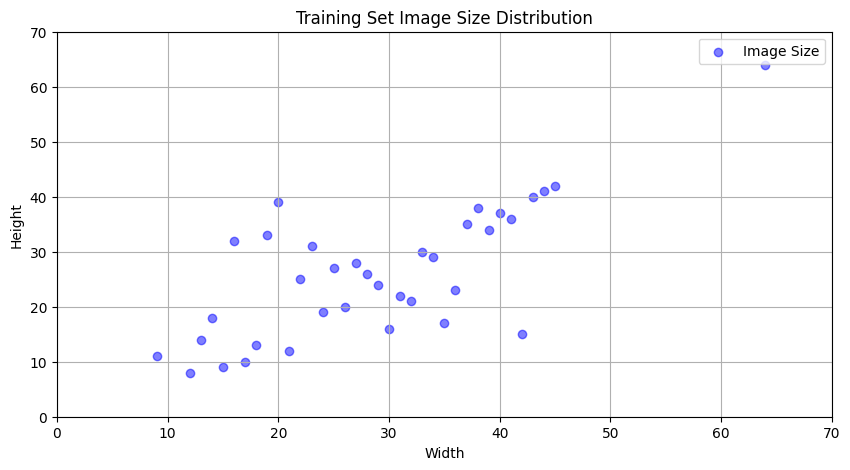

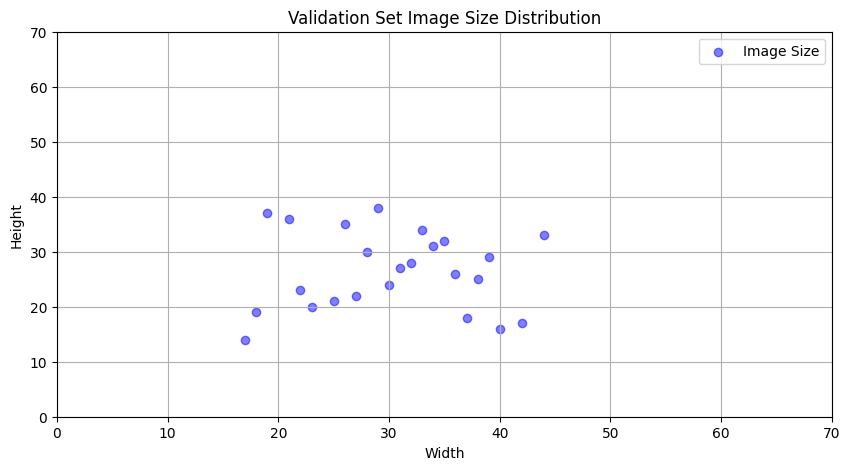

In [14]:
def plot_distribution(width_distribution, height_distribution, dataset_name):
    # Lấy danh sách các cặp chiều rộng và chiều cao
    points = [(w, h) for w, h in zip(width_distribution.keys(), height_distribution.keys())]

    # Tách danh sách chiều rộng và chiều cao
    widths, heights = zip(*points)

    # Vẽ scatter plot
    plt.figure(figsize=(10, 5))
    plt.scatter(widths, heights, color='blue', alpha=0.5, label='Image Size')
    plt.title(f'{dataset_name} Image Size Distribution')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.xlim(0, 70)  
    plt.ylim(0, 70)  
    plt.grid(True)
    plt.legend()
    plt.show()

plot_distribution(train_width_dist, train_height_dist, 'Training Set')
plot_distribution(val_width_dist, val_height_dist, 'Validation Set')

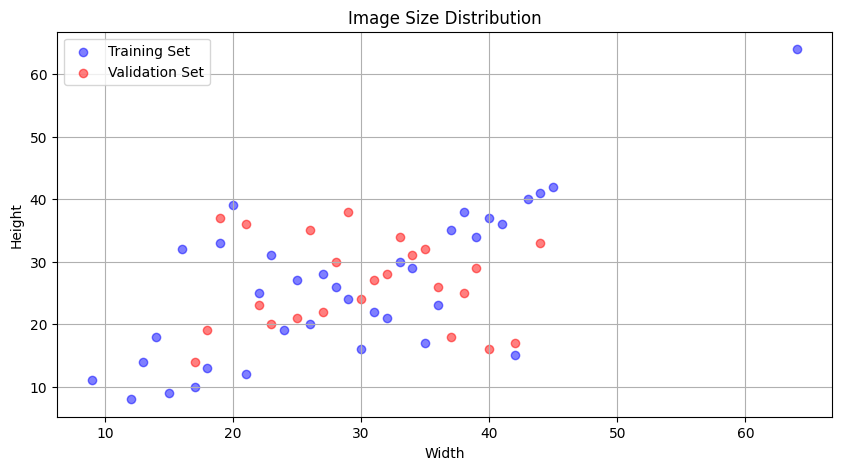

In [15]:
#vẽ cùng 1 biểu đồ
def plot_distribution(train_width_distribution, train_height_distribution, val_width_distribution, val_height_distribution):
    # Lấy danh sách các cặp chiều rộng và chiều cao cho tập huấn luyện
    train_points = [(w, h) for w, h in zip(train_width_distribution.keys(), train_height_distribution.keys())]
    train_widths, train_heights = zip(*train_points)

    # Lấy danh sách các cặp chiều rộng và chiều cao cho tập xác thực
    val_points = [(w, h) for w, h in zip(val_width_distribution.keys(), val_height_distribution.keys())]
    val_widths, val_heights = zip(*val_points)

    # Vẽ scatter plot
    plt.figure(figsize=(10, 5))
    plt.scatter(train_widths, train_heights, color='blue', alpha=0.5, label='Training Set')
    plt.scatter(val_widths, val_heights, color='red', alpha=0.5, label='Validation Set')
    plt.title('Image Size Distribution')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.grid(True)
    plt.legend()
    plt.show()

# Sử dụng hàm để vẽ biểu đồ
plot_distribution(train_width_dist, train_height_dist, val_width_dist, val_height_dist)

# **Trung bình và độ lệch chuẩn các kênh màu**

In [23]:
import torch
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# Tạo tập dữ liệu
dataset = datasets.ImageFolder(root="/kaggle/input/wb-recognition-dataset/wb_recognition_dataset/train", transform=transform)

# Create a DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=False)

def get_mean_std(loader):
    # Khởi tạo tổng số pixel và tổng giá trị trung bình, độ lệch chuẩn
    num_pixels = 0
    mean_sum = torch.zeros(3)
    std_sum = torch.zeros(3)
    
    # Lặp qua từng batch để tính tổng số pixel và tổng giá trị trung bình, độ lệch chuẩn cho từng kênh màu
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean_sum += images.mean(dim=(0, 2, 3))
        std_sum += images.std(dim=(0, 2, 3))

    # Tính toán giá trị trung bình và độ lệch chuẩn cho từng kênh màu
    mean = mean_sum / num_pixels
    std = std_sum / num_pixels

    return mean.tolist(), std.tolist()

# Tính toán giá trị trung bình và độ lệch chuẩn
mean, std = get_mean_std(loader)

# In ra giá trị trung bình và độ lệch chuẩn dưới dạng danh sách của 3 số thực
print("Mean:", mean)
print("Standard Deviation:", std)

Mean: [5.339592235031887e-07, 5.319896558830806e-07, 5.277506147649547e-07]
Standard Deviation: [1.5746847736863856e-07, 1.5842414313738118e-07, 1.6069364505710837e-07]


# **Phân bố độ sáng**

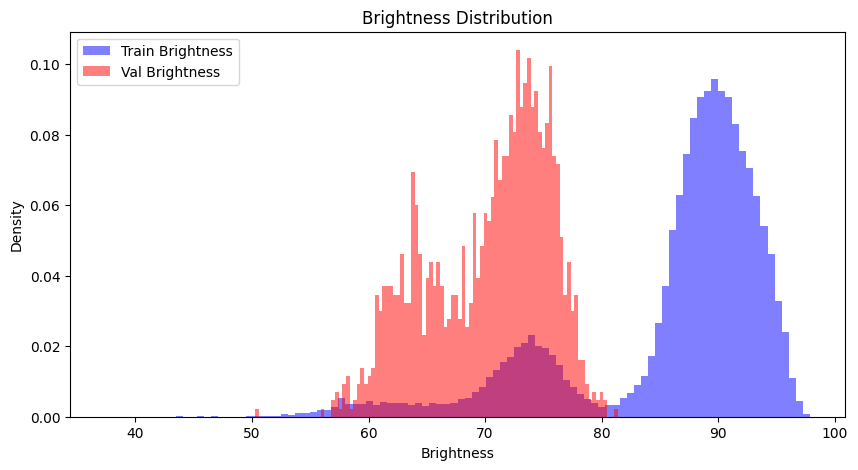

In [8]:
def calculate_brightness_distribution(data_loader):
    brightness_distribution = []

    for images, _ in data_loader:
        for image in images:
            # chuyển đổi hình ảnh sang kgian màu LAB
            lab_image = cv2.cvtColor(image.numpy().transpose(1, 2, 0), cv2.COLOR_RGB2LAB)
            #trích xuất kênh độ sáng (L) từ không gian màu LAB
            brightness = lab_image[:,:,0].mean()  # Giá trị trung bình của kênh L
            brightness_distribution.append(brightness)

    return brightness_distribution

train_brightness_distribution = calculate_brightness_distribution(dataloaders['train'])
val_brightness_distribution = calculate_brightness_distribution(dataloaders['val'])

# biểu đồ ước tính mật độ hạt nhân (KDE) của phân bổ độ sáng
plt.figure(figsize=(10, 5))
plt.hist(train_brightness_distribution, bins=100, color='blue', alpha=0.5, density=True, label='Train Brightness')
plt.hist(val_brightness_distribution, bins=100, color='red', alpha=0.5, density=True, label='Val Brightness')
plt.title('Brightness Distribution')
plt.xlabel('Brightness')
plt.ylabel('Density')
plt.legend()
plt.show()